In [1]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]


In [2]:
# A Problem is a dataset together with some fixed pre-processing.
# It could be a translation dataset with a specific tokenization,
# or an image dataset with a specific resolution.
#
# There are many problems available in Tensor2Tensor
#problems.available()

In [3]:
data_dir='../data/algorithmic_count100'
tmp_dir='../tmp/algorithmic_count100'

# Fetch the problem
problem = problems.problem("algorithmic_count100")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Skipping generator because outputs files exists at ['../data/algorithmic_count100/algorithmic_count100-train-00000-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00001-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00002-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00003-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00004-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00005-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00006-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00007-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00008-of-00010', '../data/algorithmic_count100/algorithmic_count100-train-00009-of-00010']
INFO:tensorflow:Skipping generator because outputs files exists at ['../data/algorithmic_count100/algorithmic_count100-dev-00000-of-00001']


In [4]:
# Get the encoders from the problem
encoders = problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None, mode="inputs"):
  """Input str to features dict, ready for inference"""
  inputs = encoders[mode].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers, mode="inputs"):
  """List of ints to str"""
#  integers = list(np.squeeze(integers))
#  if 1 in integers:
#    integers = integers[:integers.index(1)]
  return encoders[mode].decode(np.squeeze(integers))



In [5]:
example = tfe.Iterator(problem.dataset(Modes.EVAL, data_dir)).next()
example_inputs = example["inputs"]
example_label = example["targets"]

print("input:", decode(example_inputs, mode="inputs").split())
print("Label: %s" %  encoders["targets"].decode(example_label))

INFO:tensorflow:Reading data files from ../data/algorithmic_count100/algorithmic_count100-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
Instructions for updating:
Colocations handled automatically by placer.
input: ['77', '3', '16', '81', '1', '49', '63', '81', '16', '16', '42', '56', '65', '83', '3', '24', '5', '83', '5', '43', '3', '25', '43', '49', '20', '16', '65', '81', '65', '42', '25', '24', '16', '63', '32', '65', '48', '<EOS>']
Label: ID_17


In [6]:
encoders["targets"]._class_labels

['ID_0',
 'ID_1',
 'ID_2',
 'ID_3',
 'ID_4',
 'ID_5',
 'ID_6',
 'ID_7',
 'ID_8',
 'ID_9',
 'ID_10',
 'ID_11',
 'ID_12',
 'ID_13',
 'ID_14',
 'ID_15',
 'ID_16',
 'ID_17',
 'ID_18',
 'ID_19',
 'ID_20',
 'ID_21',
 'ID_22',
 'ID_23',
 'ID_24',
 'ID_25',
 'ID_26',
 'ID_27',
 'ID_28',
 'ID_29',
 'ID_30',
 'ID_31',
 'ID_32',
 'ID_33',
 'ID_34',
 'ID_35',
 'ID_36',
 'ID_37',
 'ID_38',
 'ID_39',
 'ID_40',
 'ID_41',
 'ID_42',
 'ID_43',
 'ID_44',
 'ID_45',
 'ID_46',
 'ID_47',
 'ID_48',
 'ID_49',
 'ID_50',
 'ID_51',
 'ID_52',
 'ID_53',
 'ID_54',
 'ID_55',
 'ID_56',
 'ID_57',
 'ID_58',
 'ID_59',
 'ID_60',
 'ID_61',
 'ID_62',
 'ID_63',
 'ID_64',
 'ID_65',
 'ID_66',
 'ID_67',
 'ID_68',
 'ID_69',
 'ID_70',
 'ID_71',
 'ID_72',
 'ID_73',
 'ID_74',
 'ID_75',
 'ID_76',
 'ID_77',
 'ID_78',
 'ID_79',
 'ID_80',
 'ID_81',
 'ID_82',
 'ID_83',
 'ID_84',
 'ID_85',
 'ID_86',
 'ID_87',
 'ID_88',
 'ID_89',
 'ID_90',
 'ID_91',
 'ID_92',
 'ID_93',
 'ID_94',
 'ID_95',
 'ID_96',
 'ID_97',
 'ID_98',
 'ID_99']

In [7]:
number_of_examples = 10000

dataset = problem.dataset(Modes.TRAIN, data_dir)
dataset = dataset.padded_batch(batch_size=number_of_examples, padded_shapes={'inputs':[None], 'targets':[1], 'batch_prediction_key':[None]})

batched_examples = tfe.Iterator(dataset).next()


eval_dataset = problem.dataset(Modes.EVAL, data_dir)
eval_dataset = eval_dataset.padded_batch(batch_size=number_of_examples, padded_shapes={'inputs':[None], 'targets':[1], 'batch_prediction_key':[None]})

eval_batched_examples = tfe.Iterator(eval_dataset).next()

INFO:tensorflow:Reading data files from ../data/algorithmic_count100/algorithmic_count100-train*
INFO:tensorflow:partition: 0 num_data_files: 10
INFO:tensorflow:Reading data files from ../data/algorithmic_count100/algorithmic_count100-dev*
INFO:tensorflow:partition: 0 num_data_files: 1


In [8]:
i = np.random.randint(len(batched_examples['inputs']))
print(i)
print(batched_examples['inputs'][i].numpy())
print(batched_examples['targets'][i].numpy())

6923


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run StridedSlice: Dst tensor is not initialized. [Op:StridedSlice] name: strided_slice/

In [9]:
def get_stats_from_examples(batched_examples):
    lengthes = []
    targets = []
    targets_ratio = []
    for example_inputs, example_targets in zip(batched_examples['inputs'], batched_examples['targets']):
        np_example_inputs = example_inputs.numpy()
        np_example_targets = example_targets.numpy()[0]
        if 0 in list(np_example_inputs):
            length = list(np_example_inputs).index(0)
        else:
            length = len(np_example_inputs)
        lengthes.append(length)
        targets.append(np_example_targets)
        targets_ratio.append(float(np_example_targets)/length)
    return lengthes, targets, targets_ratio

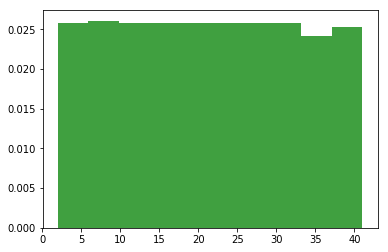

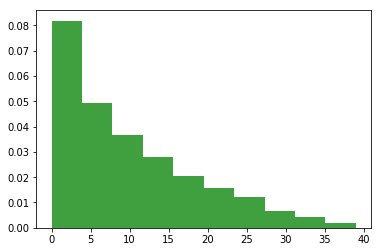

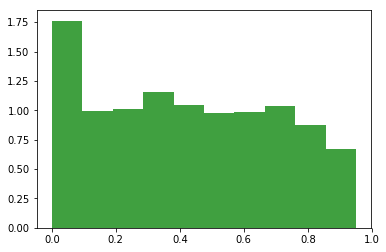

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets, targets_ratio = get_stats_from_examples(batched_examples)

n, bins, patches = plt.hist(lengthes, 10, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 10, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets_ratio, 10, density=True, facecolor='g', alpha=0.75)
plt.show()

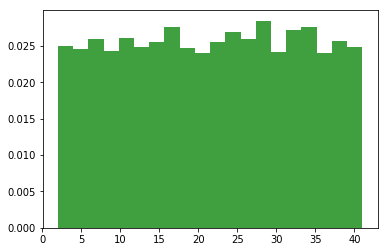

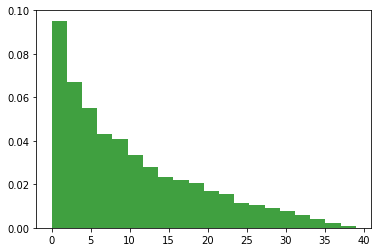

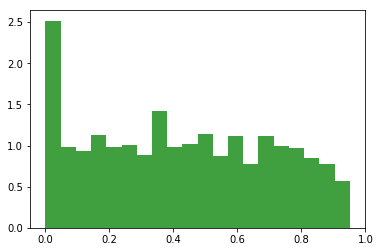

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets, targets_ratio = get_stats_from_examples(eval_batched_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets_ratio, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

In [11]:
#@title Create the model
# Create hparams and the model
model_name = "bottomup_transformer_encoder"
hparams_set = "transformer_tiny_tall"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="algorithmic_count10")
#hparams.num_heads = 1
# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
model = registry.model(model_name)(hparams, Modes.TRAIN)

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.
INFO:tensorflow:Setting T2TModel mode to 'train'


In [12]:
# Prepare for the training loop

# In Eager mode, opt.minimize must be passed a loss function wrapped with
# implicit_value_and_gradients
@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

# Setup the training data
BATCH_SIZE = 128
train_dataset = problem.dataset(Modes.TRAIN, data_dir)
train_dataset = train_dataset.padded_batch(batch_size=BATCH_SIZE, padded_shapes={'inputs':[None], 'targets':[1], 'batch_prediction_key':[None]})
train_dataset = train_dataset.repeat(None)

optimizer = tf.train.AdamOptimizer()

INFO:tensorflow:Reading data files from ../data/algorithmic_count10/algorithmic_count10-train*
INFO:tensorflow:partition: 0 num_data_files: 10


In [13]:
# Train
NUM_STEPS = 1000

for count, example in enumerate(tfe.Iterator(train_dataset)):
  example["targets"] = tf.reshape(example["targets"], [BATCH_SIZE, 1, 1, 1])  # Make it 4D.
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 50 == 0:
    print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
    break

Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_12_128.bottom
INFO:tensorflow:Transforming feature 'targets' with class_label_modality_10_128.targets_bottom
INFO:tensorflow:Building model body
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Transforming body output with class_label_modality_10_128.top
Instructions for updating:
Use keras.layers.dense instead.
Step: 0, Loss: 1.564
Step: 50, Loss: 1.464
Step: 100, Loss: 1.148
Step: 150, Loss: 1.122
Step: 200, Loss: 1.267
Step: 250, Loss: 1.506
Step: 300, Loss: 1.403
Step: 350, Loss: 1.300
Step: 400, Loss: 1.428
Step: 450, Loss: 1.484


KeyboardInterrupt: 

In [14]:
model.set_mode(Modes.EVAL)
eval_dataset = problem.dataset(Modes.EVAL, data_dir)

# Create eval metric accumulators for accuracy (ACC) and accuracy in
# top 5 (ACC_TOP5)
metrics_accum, metrics_result = metrics.create_eager_metrics(
    [metrics.Metrics.ACC, metrics.Metrics.ACC_TOP5])

for count, example in enumerate(tfe.Iterator(eval_dataset)):
  if count >= 200:
    break

  
  # Make the inputs and targets 4D
  example["targets"] = tf.reshape(example["targets"], [1, 1, 1, 1])
  example["inputs"] = tf.reshape(example["inputs"], [1, 1, -1, 1])

  # Call the model
  predictions, _ = model(example)

  # Compute and accumulate metrics
  metrics_accum(predictions, example["targets"])

# Print out the averaged metric values on the eval data
for name, val in metrics_result().items():
  print("%s: %.2f" % (name, val))

INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.label_smoothing to 0.0
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0
INFO:tensorflow:Reading data files from ../data/algorithmic_count10/algorithmic_count10-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
accuracy: 0.18
accuracy_top5: 0.60


In [35]:
# Make the inputs and targets 4D

batched_examples["targets"] = tf.reshape(batched_examples["targets"], [number_of_examples, 1, 1, 1])
batched_examples["inputs"] = tf.reshape(batched_examples["inputs"], [number_of_examples, 1, -1, 1])

In [49]:
i = np.random.randint(len(batched_examples['inputs']))
print(i)
print(batched_examples['inputs'][i].numpy())
print(batched_examples['targets'][i].numpy())
predictions, _ = model(batched_examples)
print(np.argmax(predictions[i].numpy()))

772
[ 5  4  6 10  3  9 11  8  7  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[10]
8
